# Growth Limiation - Create a grid of factor most limiting growth at each year for summer months, for each phytoplankton group... throuhout the whole Arctic Ocean. 
1. find what areas around the Arctic are limited by what, and 
2. see how you can plot difference plots or show how these differ between high and low temp, ice and NO$_3$ years. 

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
#import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy

In [2]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
files = sorted(glob.glob(f'{path}/*.nc', recursive=True),key=numericalSort)
ds= xr.open_mfdataset(files,combine='by_coords')

## Check what these files are, because they could save a lot of time... 

In [5]:
diat3_ind = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/diat3_lim_index_remap.nc', decode_times=False)
pp_ind = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/pp_lim_index_remap.nc',decode_times=False)
diat2_ind = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/diat2_lim_index_remap.nc',decode_times=False)
diat1_ind = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/diat1_lim_index_remap.nc',decode_times=False)
mp1_ind = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/mp1_lim_index_remap.nc',decode_times=False)
mp2_ind = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/mp2_lim_index_remap.nc',decode_times=False)
mp3_ind = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/mp3_lim_index_remap.nc',decode_times=False)
mp4_ind = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/mp4_lim_index_remap.nc',decode_times=False)

In [6]:
diat3_val = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/diat3_lim_value_remap.nc', decode_times=False)
pp_val = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/pp_lim_value_remap.nc',decode_times=False)
diat2_val = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/diat2_lim_value_remap.nc',decode_times=False)
diat1_val = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/diat1_lim_value_remap.nc',decode_times=False)
mp1_val = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/mp1_lim_value_remap.nc',decode_times=False)
mp2_val = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/mp2_lim_value_remap.nc',decode_times=False)
mp3_val = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/mp3_lim_value_remap.nc',decode_times=False)
mp4_val = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/mp4_lim_value_remap.nc',decode_times=False)

In [7]:
diat3_val.diat3_lim_value

<xarray.DataArray 'diat3_lim_value' (time: 63, month: 12, lat: 180, lon: 360)>
dask.array<open_dataset-diat3_lim_value, shape=(63, 12, 180, 360), dtype=float64, chunksize=(63, 12, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * month    (month) float64 2.266e+04 2.269e+04 2.272e+04 ... 2.296e+04 2.3e+04
Attributes:
    long_name:  diatom 3 maximum limitation value, carbon biomass weighted av...

## Set up colorbar

In [8]:
# colors for each variable 
# temperature (Blue)
temperature3 = ''
temperature        = '#e0f3f8'
temperature1       = '#abd9e9'
temperature2       = '#74add1'
# light (yellow)
light2   = '#fdae61'
light1   ='#fee090'
light   ='#ffffbf'
light3=''
# nutrients (Green)
nitrate     = '#AFE1AF'
nitrate1     ='#00A36C'
nitrate2     ='#097969'

from matplotlib.colors import LinearSegmentedColormap
color_temp = [temperature,temperature1,temperature2]
color_light = [light,light1,light2]
color_nutrients = [nitrate,nitrate1,nitrate2]

cmap_name = 'my_list'
cm_temp = LinearSegmentedColormap.from_list(
        cmap_name, color_temp, N=3)
cm_light = LinearSegmentedColormap.from_list(
        cmap_name, color_light, N=3)
cm_nutrients = LinearSegmentedColormap.from_list(
        cmap_name, color_nutrients, N=3)

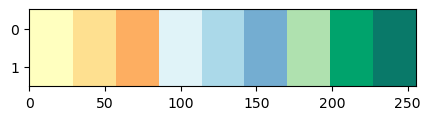

In [9]:
N = 3 # number of colors to extract from each of the base_cmaps below
phyto = [cm_light,cm_temp,cm_nutrients]

n_base = len(phyto)
# we go from 0.2 to 0.8 below to avoid having several whites and blacks in the resulting cmaps
colors_phyto = np.concatenate([plt.get_cmap(name)(np.linspace(0,1,N)) for name in phyto])
cm_phyto = mpl.colors.ListedColormap(colors_phyto)

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(1,1,figsize=(5,1))
ax.imshow(gradient, aspect='auto', cmap=cm_phyto)

## Plot the regional limitaiton during the summer to make sure these are working correctly! 

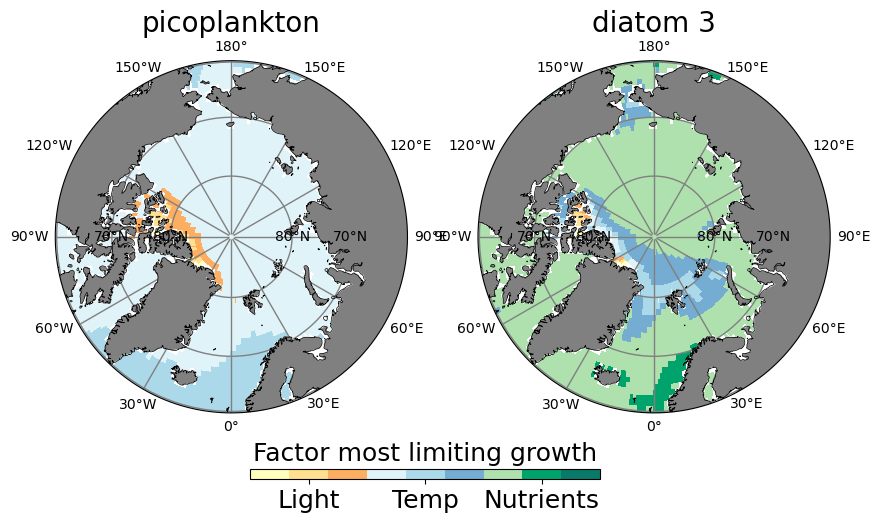

CPU times: user 6.22 s, sys: 2.48 s, total: 8.7 s
Wall time: 10.1 s


<Figure size 640x480 with 0 Axes>

In [11]:
%%time
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
from cartopy.util import add_cyclic_point
r_limit = 3214068.5 #from: ax.get_ylim() of above plot
lonlatproj = ccrs.PlateCarree()
my_projn = ccrs.Orthographic(central_longitude=0, central_latitude=90)
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,
                           circle_path.codes.copy())
r_extent = r_limit*1.0001
fig = plt.figure(figsize=(10,5))
# ------------------------- Picoplankton ---------------------------
# Summer
ax = fig.add_subplot(1, 2, 1, projection=my_projn) 
ax.set_title("picoplankton",fontsize=20)
pp_lims = (pp_val.pp_lim_value.where(pp_val.pp_lim_value < 0.9) + pp_ind.pp_lim_index.where(pp_val.pp_lim_value < 0.9))
summer, lon = add_cyclic_point(np.nanmean(pp_lims[:,5:8,:,:], axis=(0,1)), coord=diat3_val.lon, axis=1)
x, y = np.meshgrid(lon,diat3_val.lat)
cf = ax.pcolormesh(x,y,summer,cmap=cm_phyto,transform=lonlatproj, vmin=0, vmax=3)
ax.coastlines(lw=0.5, color="black", zorder=20)
gls = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), lw=1, color="gray",
        y_inline=True, xlocs=range(-180,180,30), ylocs=range(-80,91,10))
ax.set_xlim(-r_extent, r_extent)
ax.set_ylim(-r_extent, r_extent)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_boundary(circle_path)

# ------------------------- Diatom 3 ---------------------------
# Summer
ax = fig.add_subplot(1, 2, 2, projection=my_projn) 
ax.set_title("diatom 3",fontsize=20)
diat3_lims = (diat3_val.diat3_lim_value.where(diat3_val.diat3_lim_value < 0.9) + diat3_ind.diat3_lim_index.where(diat3_val.diat3_lim_value < 0.9))
summer, lon = add_cyclic_point(np.nanmean(diat3_lims[:,5:8,:,:], axis=(0,1)), coord=diat3_val.lon, axis=1)
x, y = np.meshgrid(lon,diat3_val.lat)
cff = ax.pcolormesh(x,y,summer,cmap=cm_phyto,transform=lonlatproj, vmin=0, vmax=3)
ax.coastlines(lw=0.5, color="black", zorder=20)
gls = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), lw=1, color="gray",
        y_inline=True, xlocs=range(-180,180,30), ylocs=range(-80,91,10))
ax.set_xlim(-r_extent, r_extent)
ax.set_ylim(-r_extent, r_extent)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_boundary(circle_path)

cbar_ax = fig.add_axes([0.32, 0.01, 0.35, 0.02])
cbar = fig.colorbar(cf, cax=cbar_ax, shrink=0.75, spacing='uniform',ticks=[0.5,1.5,2.5],orientation="horizontal")
cbar.ax.set_xticklabels(['Light','Temp', 'Nutrients'], fontsize = 18)
cbar.ax.set_title('Factor most limiting growth', fontsize = 18)
plt.show()
plt.tight_layout()

### This confirms that it does show the same trends as it does the none 1 degree grid

In [10]:
%%time
pp_lims = (pp_val.pp_lim_value.where(pp_val.pp_lim_value < 0.9) + pp_ind.pp_lim_index.where(pp_val.pp_lim_value < 0.9))
mp1_lims = (mp1_val.mp1_lim_value.where(mp1_val.mp1_lim_value < 0.9) + mp1_ind.mp1_lim_index.where(mp1_val.mp1_lim_value < 0.9))
mp2_lims = (mp2_val.mp2_lim_value.where(mp2_val.mp2_lim_value < 0.9) + mp2_ind.mp2_lim_index.where(mp2_val.mp2_lim_value < 0.9))
mp3_lims = (mp3_val.mp3_lim_value.where(mp3_val.mp3_lim_value < 0.9) + mp3_ind.mp3_lim_index.where(mp3_val.mp3_lim_value < 0.9))
mp4_lims = (mp4_val.mp4_lim_value.where(mp4_val.mp4_lim_value < 0.9) + mp4_ind.mp4_lim_index.where(mp4_val.mp4_lim_value < 0.9))
diat1_lims = (diat1_val.diat1_lim_value.where(diat1_val.diat1_lim_value < 0.9) + diat1_ind.diat1_lim_index.where(diat1_val.diat1_lim_value < 0.9))
diat2_lims = (diat2_val.diat2_lim_value.where(diat2_val.diat2_lim_value < 0.9) + diat2_ind.diat2_lim_index.where(diat2_val.diat2_lim_value < 0.9))
diat3_lims = (diat3_val.diat3_lim_value.where(diat3_val.diat3_lim_value < 0.9) + diat3_ind.diat3_lim_index.where(diat3_val.diat3_lim_value < 0.9))

CPU times: user 53.6 ms, sys: 0 ns, total: 53.6 ms
Wall time: 57 ms


In [11]:
%%time
phyto_lims_summer = np.stack([np.nanmean(pp_lims[:,5:8,:,:],axis=1),
                       np.nanmean(mp1_lims[:,5:8,:,:],axis=1),
                       np.nanmean(diat1_lims[:,5:8,:,:],axis=1),
                       np.nanmean(mp2_lims[:,5:8,:,:],axis=1),
                       np.nanmean(diat2_lims[:,5:8,:,:],axis=1),
                       np.nanmean(mp3_lims[:,5:8,:,:],axis=1),
                       np.nanmean(diat3_lims[:,5:8,:,:],axis=1),
                       np.nanmean(mp4_lims[:,5:8,:,:],axis=1)
                      ],axis=0)

CPU times: user 3.62 s, sys: 6.76 s, total: 10.4 s
Wall time: 15.8 s


In [12]:
%%time
phyto_lims_fall = np.stack([np.nanmean(pp_lims[:,8:11,:,:],axis=1),
                       np.nanmean(mp1_lims[:,8:11,:,:],axis=1),
                       np.nanmean(diat1_lims[:,8:11,:,:],axis=1),
                       np.nanmean(mp2_lims[:,8:11,:,:],axis=1),
                       np.nanmean(diat2_lims[:,8:11,:,:],axis=1),
                       np.nanmean(mp3_lims[:,8:11,:,:],axis=1),
                       np.nanmean(diat3_lims[:,8:11,:,:],axis=1),
                       np.nanmean(mp4_lims[:,8:11,:,:],axis=1)
                      ],axis=0)

CPU times: user 3.49 s, sys: 5.3 s, total: 8.8 s
Wall time: 33.9 s


In [13]:
%%time
phyto_lims_spring = np.stack([np.nanmean(pp_lims[:,2:5,:,:],axis=1),
                       np.nanmean(mp1_lims[:,2:5,:,:],axis=1),
                       np.nanmean(diat1_lims[:,2:5,:,:],axis=1),
                       np.nanmean(mp2_lims[:,2:5,:,:],axis=1),
                       np.nanmean(diat2_lims[:,2:5,:,:],axis=1),
                       np.nanmean(mp3_lims[:,2:5,:,:],axis=1),
                       np.nanmean(diat3_lims[:,2:5,:,:],axis=1),
                       np.nanmean(mp4_lims[:,2:5,:,:],axis=1)
                      ],axis=0)

CPU times: user 3.47 s, sys: 5.29 s, total: 8.76 s
Wall time: 17.4 s


In [14]:
%%time
phyto_lims_winter = np.stack([np.nanmean(pp_lims[:,list(range(2)) + [-1],:,:],axis=1),
                       np.nanmean(mp1_lims[:,list(range(2)) + [-1],:,:],axis=1),
                       np.nanmean(diat1_lims[:,list(range(2)) + [-1],:,:],axis=1),
                       np.nanmean(mp2_lims[:,list(range(2)) + [-1],:,:],axis=1),
                       np.nanmean(diat2_lims[:,list(range(2)) + [-1],:,:],axis=1),
                       np.nanmean(mp3_lims[:,list(range(2)) + [-1],:,:],axis=1),
                       np.nanmean(diat3_lims[:,list(range(2)) + [-1],:,:],axis=1),
                       np.nanmean(mp4_lims[:,list(range(2)) + [-1],:,:],axis=1)
                      ],axis=0)

CPU times: user 3.61 s, sys: 5.35 s, total: 8.95 s
Wall time: 15.1 s


## Create colormap with three different colors, representing temperature, light and nutrients. 

In [15]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0.9994925028835063, 0.9192618223760093, 0.6061361014994233),(0.45066769191336664, 0.7509983339741125, 0.7703857490708702),(0.6825187635707243, 0.810691907283208, 0.6352470180118206)]

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=3)

## Create grid, with phytoplankton types in the y axis, and years in the x axis, that are color coded with the most limiting factor. 

In [16]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

In [17]:
years = ['1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']

## this is the actual values of the differnt regions that I want 
Arctic Regions

| Initials  | Name                       | Latitude          | Longitude             |
|-----------|----------------------------|-------------------|-----------------------|
| `ao`      | Central Arctic             | $90^oN$ to $80^oN$ |  All                 |
| `cs`      | Chukchi Sea                | $80^oN$ to $60^oN$ |$-180^o$ to $-155^oW$ |
| `bs`      | Beaufort Sea               | $80^oN$ to $60^oN$ |$-155^oW$ to $-125^oW$|
| `ca`      | Canadian Archipelago       | $80^oN$ to $60^oN$ |$-125^oW$ to $-100^oW$ |
| `bb`      | Baffin Sea                 | $80^oN$ to $60^oN$ |$-100^oW$ to $-45^oW$  |                      
| `ess`     | Eastern Siberian Sea       | $80^oN$ to $60^oN$ |$145^oE$ to $180^o$   |                       
| `ls`      | Laptev Sea                 | $80^oN$ to $60^oN$ |$90^oE$ to $145^oE$   |                      
| `ks`      | Kara Sea                   | $80^oN$ to $60^oN$ |$53^oE$ to $90^oE$    |                      
| `bts`     | Barents Sea                | $80^oN$ to $60^oN$ |$20^oE$ to $53^oE$    |                      
| `ns`      | Nordic Sea                 | $80^oN$ to $60^oN$ |$-45^oW$ to $20^oE$   | 


|Region| Latitude | Longitude | Matrix Inputs       |
|------|----------|-----------|---------------------|
|`ao`  |170:180   |:          |`[:,170:180,:]`      |
|`cs`  |149:170   |0:25       |`[:,149:170,0:25]`   |
|`bs`  |149:170   | 25:55     |`[:,149:170,25:55]`  |
|`ca`  |149:170   |55:80     |`[:,149:170,55:110]` |
|`bb`  |149:170   |80:135    |`[:,149:170,110:135]`|
|`ess` |149:170   |325:360    |`[:149:170,325:360]` |
|`ls`  |149:170   |270:325    |`[:,149:170,270:325]`|
|`ks`  |149:170   |233:270    |`[:,149:170,233:270]`|
|`bts` |149:170   |200:233    |`[:,149:170,205:233]`|
|`ns`  |149:170   |155:200    |`[:,149:170,155:205]`|

In [23]:
phyto_lims_summer[:,1::,:,:].shape

(8, 62, 180, 360)

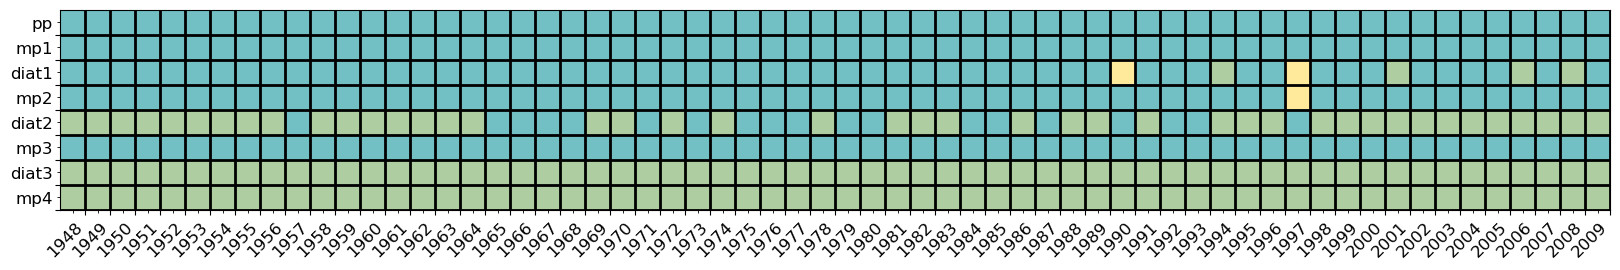

In [18]:
region = 'ao'
season = 'summer'
data =  np.nanmean(phyto_lims_summer[:,0:62,170:180,:],axis=(2,3))# Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm, vmin=0, vmax=2)


# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)

plt.show()

## Central Arctic Ocean 

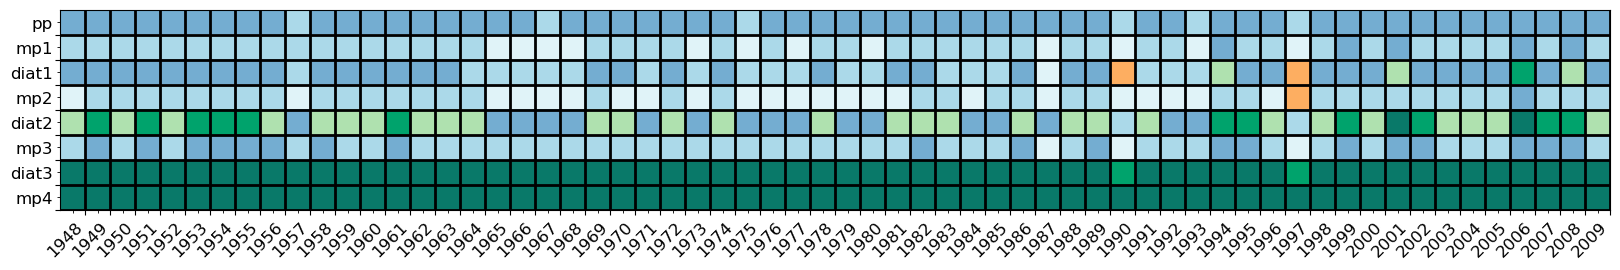

In [19]:
region = 'ao'
season = 'summer'
data =  np.nanmean(phyto_lims_summer[:,0:62,170:180,:],axis=(2,3))# Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm_phyto, vmin=0,vmax=2)


# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)

plt.show()
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
region = 'ao'
season = 'summer'
fig.savefig(f'{file}central_{region}_{season}.png', dpi=600, bbox_inches='tight')

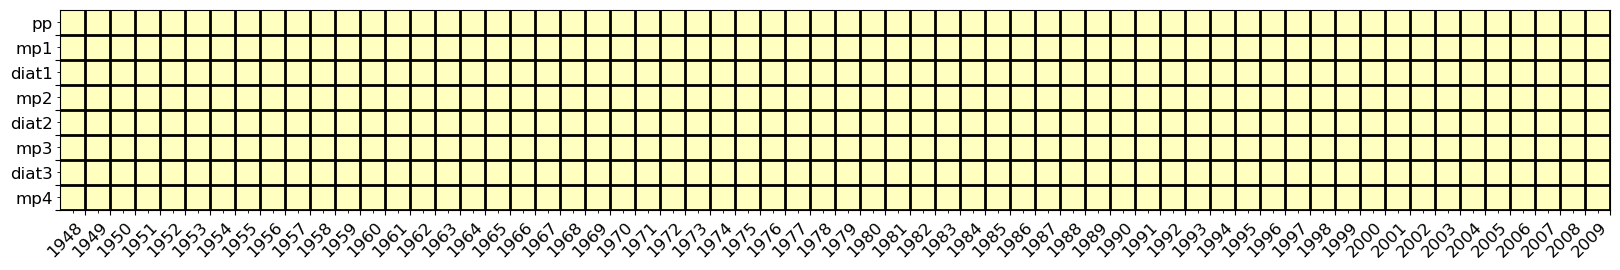

In [20]:
region = 'ao'
season = 'spring'
data =  np.nanmean(phyto_lims_spring[:,0:62,170:180,:],axis=(2,3))# Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm_phyto,vmin=0,vmax=2)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)

plt.show()
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}.png', dpi=600, bbox_inches='tight')

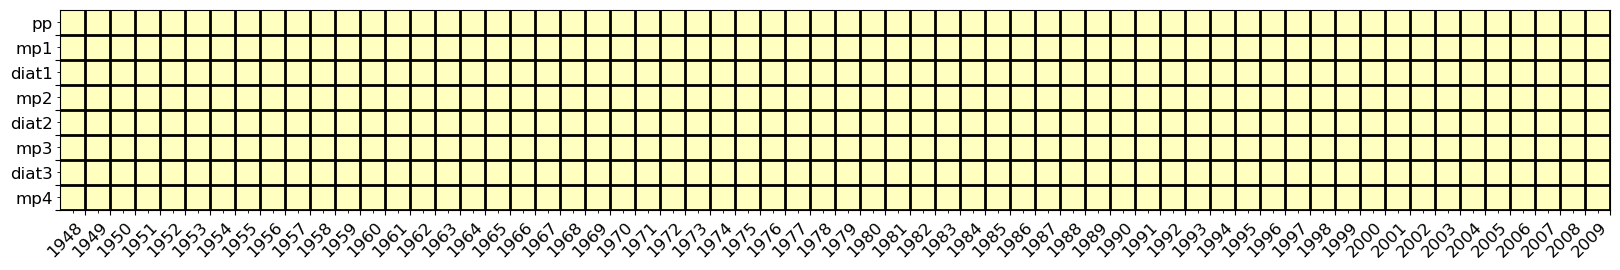

In [21]:
region = 'ao'
season = 'winter'
data =  np.nanmean(phyto_lims_winter[:,0:62,170:180,:],axis=(2,3))# Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm_phyto, vmin=0,vmax=2)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)

plt.show()
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}.png', dpi=600, bbox_inches='tight')

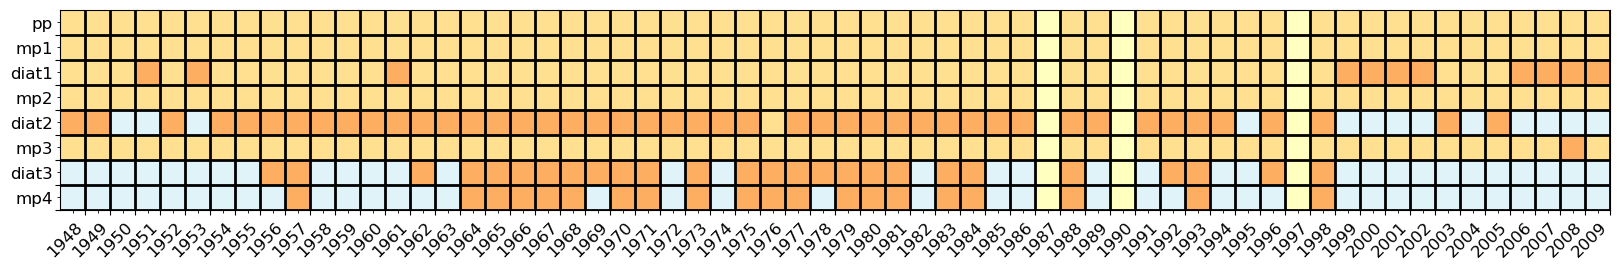

In [22]:
region = 'ao'
season = 'fall'
data =  np.nanmean(phyto_lims_fall[:,0:62,170:180,:],axis=(2,3))# Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data,cmap=cm_phyto, vmin=0,vmax=2)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)

plt.show()
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}.png', dpi=600, bbox_inches='tight')

# Whole Arctic Ocean

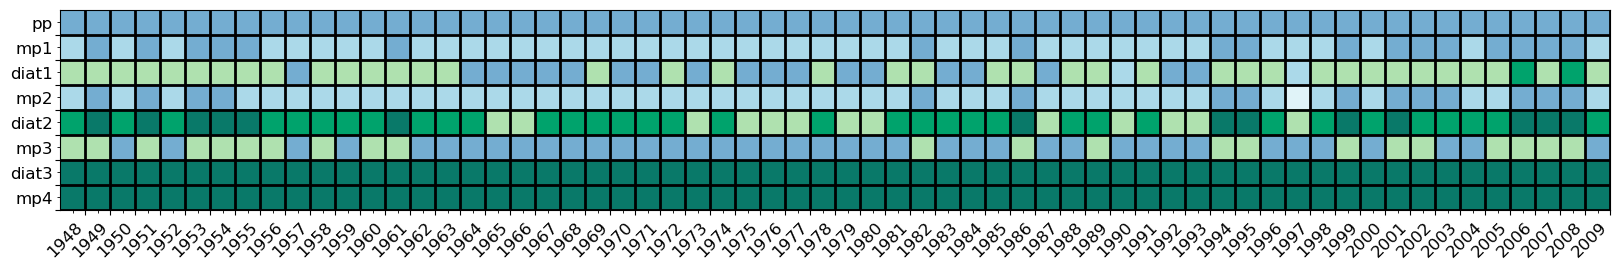

In [23]:
region = 'arctic_ocean'
season = 'summer'
data =  np.nanmean(phyto_lims_summer[:,0:62,149:180,:],axis=(2,3))# Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm_phyto, vmin=0,vmax=2)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)

plt.show()
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}whole_{region}_{season}.png', dpi=600, bbox_inches='tight')

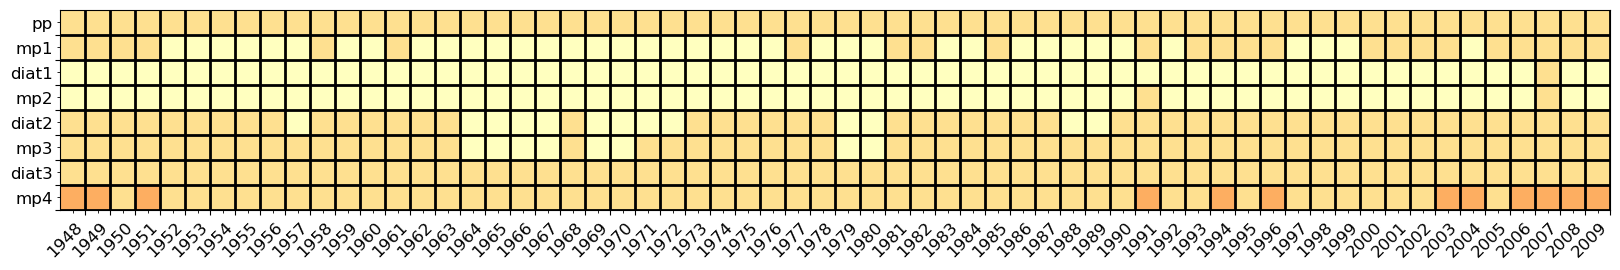

In [24]:
region = 'arctic_ocean'
season = 'spring'
data =  np.nanmean(phyto_lims_spring[:,0:62,149:180,:],axis=(2,3))# Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm_phyto, vmin=0,vmax=2)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)

plt.show()
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}whole_{region}_{season}.png', dpi=600, bbox_inches='tight')

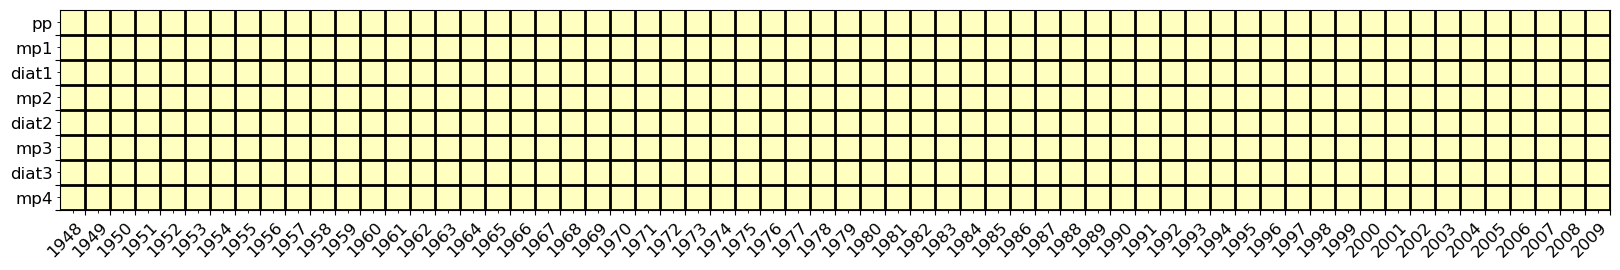

In [25]:
region = 'arctic_ocean'
season = 'winter'
data =  np.nanmean(phyto_lims_winter[:,0:62,149:180,:],axis=(2,3))# Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm_phyto, vmin=0,vmax=2)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)

plt.show()
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}whole_{region}_{season}.png', dpi=600, bbox_inches='tight')

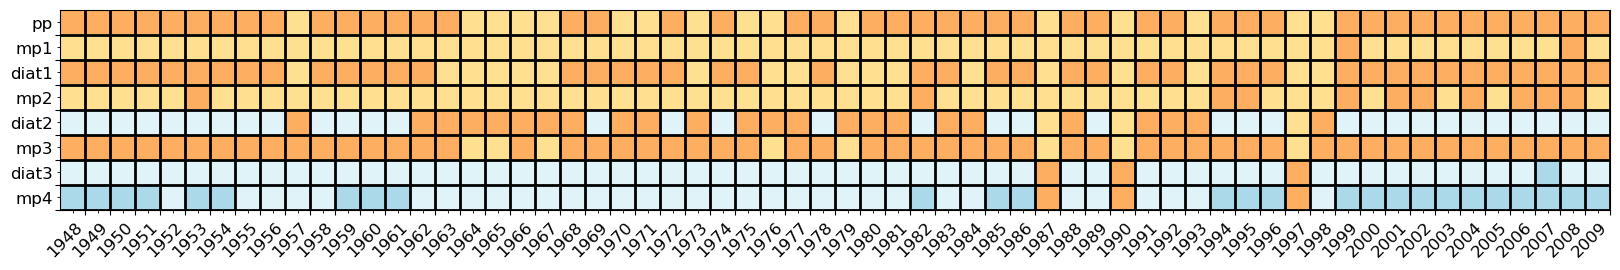

In [26]:
region = 'arctic_ocean'
season = 'fall'
data =  np.nanmean(phyto_lims_fall[:,0:62,149:180,:],axis=(2,3))# Should be 9 by 63... 

# Create figure 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm_phyto, vmin=0,vmax=2)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticks(np.arange(0, 62, 1), minor=True);
ax.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels([]);
ax.set_yticks(np.arange(0, 8, 1), minor=True);
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'], minor=True, fontsize=12)

plt.show()
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}whole_{region}_{season}.png', dpi=600, bbox_inches='tight')

## Import the phytoplankton biomass (mmol m-3) averaged through the top 150m

In [27]:
# Units should be mmol m-3 (averaged through the top 150m)
path = '/glade/u/home/gabyn/scratch/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_pbmss_ch2_1948_2009_'
ppC = xr.open_mfdataset(f'{path}ppC.nc') # mmol m-3
mp1C = xr.open_mfdataset(f'{path}mp1C.nc')# mmol m-3
mp2C = xr.open_mfdataset(f'{path}mp2C.nc')# mmol m-3
mp3C = xr.open_mfdataset(f'{path}mp3C.nc')# mmol m-3
mp4C = xr.open_mfdataset(f'{path}mp4C.nc')# mmol m-3
diat1C = xr.open_mfdataset(f'{path}diat1C.nc')# mmol m-3
diat2C = xr.open_mfdataset(f'{path}diat2C.nc')# mmol m-3
diat3C = xr.open_mfdataset(f'{path}diat3C.nc')# mmol m-3
diazC = xr.open_mfdataset(f'{path}diazC.nc')# mmol m-3
photoC_TOT = xr.open_mfdataset(f'{path}photoC_TOT.nc') # units are mmol m-3 s-1

In [28]:
%%time
bmss = np.stack([ppC.ppC_150m_zint, mp1C.mp1C, diazC.diazC, 
                   mp2C.mp2C, diat1C.diat1C, diat2C.diat2C, 
                   mp3C.mp3C, diat3C.diat3C, mp4C.mp4C]) # units of mmol m-3 (depth averaged through the top 150m)
bmss_tot = np.nansum(bmss,axis=0)

CPU times: user 1.65 s, sys: 3.79 s, total: 5.44 s
Wall time: 8.04 s


In [29]:
%%time
bmss_ao = np.nanmean(bmss_tot[:,:,170:180,:], axis=(2,3))
bmss_ao_anom = bmss_ao[:,5:8]-np.nanmean(bmss_ao[:,5:8],axis=0)

CPU times: user 8.25 ms, sys: 8.35 ms, total: 16.6 ms
Wall time: 80 ms


# Now plot out all of the anomalies

In [30]:
%%time
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_TEMP*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

CPU times: user 655 ms, sys: 278 ms, total: 933 ms
Wall time: 14.5 s


In [31]:
%%time
temp_ds_inter = np.empty([63,12,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    temp_ds_inter[i,:,:,:] = ds.TEMP[x[i]:x[i]+12,0,:,:]

CPU times: user 576 ms, sys: 185 ms, total: 761 ms
Wall time: 24.9 s


In [32]:
%%time
temp_ao = np.nanmean(temp_ds_inter[:,:,170:180,:], axis=(2,3))
temp_ao_anom = temp_ao[:,5:8]-np.nanmean(temp_ao[:,5:8],axis=0)

CPU times: user 10.8 ms, sys: 4.8 ms, total: 15.6 ms
Wall time: 34.9 ms


In [33]:
%%time
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_ECOSYS_IFRAC*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

CPU times: user 454 ms, sys: 79.5 ms, total: 533 ms
Wall time: 2.59 s


In [34]:
%%time
ECOSYS_IFRAC_ds_inter = np.empty([63,12,180,360])
ECOSYS_IFRAC_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    ECOSYS_IFRAC_ds_inter[i,:,:,:] = ds.ECOSYS_IFRAC[x[i]:x[i]+12,:,:]

CPU times: user 525 ms, sys: 188 ms, total: 713 ms
Wall time: 1.71 s


In [35]:
%%time
ECOSYS_IFRAC_ao = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,170:180,:], axis=(2,3))
ECOSYS_IFRAC_ao_anom = ECOSYS_IFRAC_ao[:,5:8]-np.nanmean(ECOSYS_IFRAC_ao[:,5:8],axis=0)

CPU times: user 11.7 ms, sys: 0 ns, total: 11.7 ms
Wall time: 14.6 ms


In [36]:
%%time
NO3_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_NO3*.nc', recursive=True))
ds= xr.open_mfdataset(NO3_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

CPU times: user 543 ms, sys: 211 ms, total: 753 ms
Wall time: 13.5 s


In [37]:
%%time
NO3_ds_inter = np.empty([63,12,180,360])
NO3_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    NO3_ds_inter[i,:,:,:] = ds.NO3[x[i]:x[i]+12,0,:,:]

CPU times: user 578 ms, sys: 186 ms, total: 764 ms
Wall time: 24.9 s


In [38]:
%%time
NO3_ao = np.nanmean(NO3_ds_inter[:,:,170:180,:], axis=(2,3))
NO3_ao_anom = NO3_ao[:,5:8]-np.nanmean(NO3_ao[:,5:8],axis=0)

CPU times: user 11.8 ms, sys: 0 ns, total: 11.8 ms
Wall time: 14.8 ms


In [39]:
NO3_ao_anom.shape

(63, 3)

In [40]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec

## Arctic Regions
|Region| Latitude | Longitude | Matrix Inputs       |
|------|----------|-----------|---------------------|
|`ao`  |170:180   |:          |`[:,170:180,:]`      |
|`cs`  |149:170   |0:25       |`[:,149:170,0:25]`   |
|`bs`  |149:170   | 25:55     |`[:,149:170,25:55]`  |
|`ca`  |149:170   |55:80     |`[:,149:170,55:110]` |
|`bb`  |149:170   |80:135    |`[:,149:170,110:135]`|
|`ess` |149:170   |325:360    |`[:149:170,325:360]` |
|`ls`  |149:170   |270:325    |`[:,149:170,270:325]`|
|`ks`  |149:170   |233:270    |`[:,149:170,233:270]`|
|`bts` |149:170   |200:233    |`[:,149:170,205:233]`|
|`ns`  |149:170   |155:200    |`[:,149:170,155:205]`|

# Central Arctic Ocean

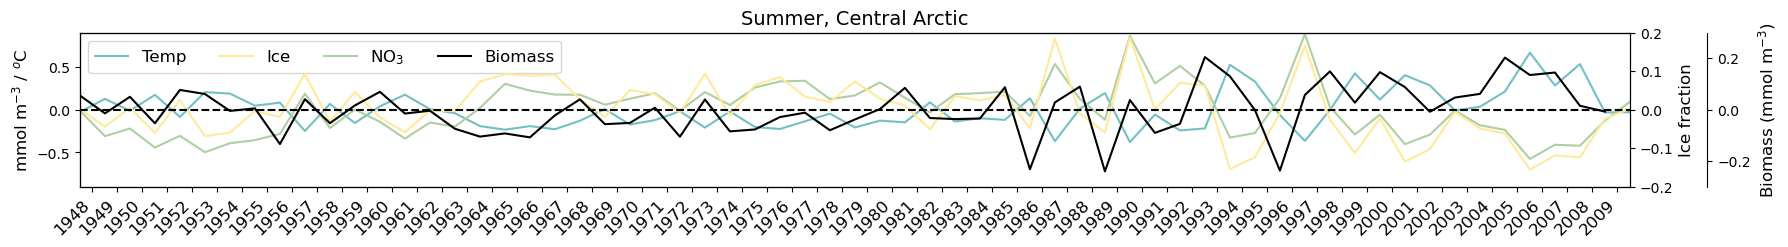

In [41]:
region = 'ao'
season = 'summer'
fig = plt.figure(figsize=(20, 2))
ax1 = fig.add_subplot(1,1,1);
ax2=ax1.twinx()
ln1=ax1.plot(np.nanmean(temp_ao_anom,axis=1),color=cm(1),label = 'Temp')
ln2=ax2.plot(np.nanmean(ECOSYS_IFRAC_ao_anom,axis=1),color=cm(0),label = 'Ice')
ln3=ax1.plot(np.nanmean(NO3_ao_anom,axis=1), color=cm(2),label = 'NO$_3$')
ax1.set_title('Summer, Central Arctic', fontsize=14)
ax1.set_xticks(np.arange(0.5, 62, 1));
ax1.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax1.set_ylim(-0.9,0.9)
ax2.set_ylabel("Ice fraction",color='k',fontsize=12)
ax1.set_ylabel("mmol m$^{-3}$ / $^o$C",color="k",fontsize=12)
plt.axhline(y=0, color='k', linestyle='--')
ax2.set_ylim(-0.2,0.2)
ax3=ax1.twinx(); ax3.spines['right'].set_position(("axes", 1.05))
ln4 = ax3.plot(np.nanmean(bmss_ao_anom,axis=1), color='k',label = 'Biomass')
ax3.set_ylim(-0.3,0.3)
ax3.set_ylabel("Biomass (mmol m$^{-3})$",color="k",fontsize=12)
ax1.margins(x=0)
lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2,ncol=4,fontsize=12)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}central_{region}_{season}_anomaly.png', dpi=600, bbox_inches='tight')

# Whole Arctic 

In [48]:
%%time
temp_ao = np.nanmean(temp_ds_inter[:,0:62,149:180,:], axis=(2,3))
temp_ao_anom = temp_ao[:,5:8]-np.nanmean(temp_ao[:,5:8],axis=0)

ECOSYS_IFRAC_ao = np.nanmean(ECOSYS_IFRAC_ds_inter[:,0:62,149:180,:], axis=(2,3))
ECOSYS_IFRAC_ao_anom = ECOSYS_IFRAC_ao[:,5:8]-np.nanmean(ECOSYS_IFRAC_ao[:,5:8],axis=0)

NO3_ao = np.nanmean(NO3_ds_inter[:,0:62,149:180,:], axis=(2,3))
NO3_ao_anom = NO3_ao[:,5:8]-np.nanmean(NO3_ao[:,5:8],axis=0)

bmss_ao = np.nanmean(bmss_tot[:,:,149:180,:], axis=(2,3))
bmss_ao_anom = bmss_ao[:,5:8]-np.nanmean(bmss_ao[:,5:8],axis=0)

CPU times: user 120 ms, sys: 61 ms, total: 181 ms
Wall time: 195 ms


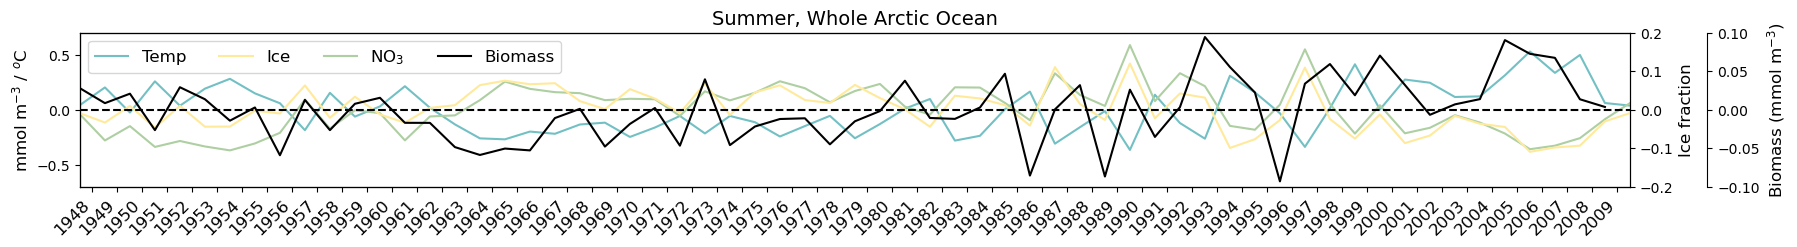

In [50]:
region = 'wao'
season = 'summer'

cmap= matplotlib.cm.get_cmap('Reds', 10)
cmap1= matplotlib.cm.get_cmap('Blues', 10)

fig = plt.figure(figsize=(20, 2))

# Subplot 1
ax1 = fig.add_subplot(1,1,1);
ax2=ax1.twinx()
ln1=ax1.plot(np.nanmean(temp_ao_anom,axis=1),color=cm(1),label = 'Temp')
ln2=ax2.plot(np.nanmean(ECOSYS_IFRAC_ao_anom,axis=1),color=cm(0),label = 'Ice')
ln3=ax1.plot(np.nanmean(NO3_ao_anom,axis=1), color=cm(2),label = 'NO$_3$')
ax1.set_title('Summer, Whole Arctic Ocean', fontsize=14)
ax1.set_xticks(np.arange(0.5, 62, 1));
ax1.set_xticklabels(years,rotation=45, ha="right", fontsize=12)
ax1.set_ylim(-0.7,0.7)
ax2.set_ylabel("Ice fraction",color='k',fontsize=12)
ax1.set_ylabel("mmol m$^{-3}$ / $^o$C",color="k",fontsize=12)
plt.axhline(y=0, color='k', linestyle='--')
ax2.set_ylim(-0.2,0.2)
ax3=ax1.twinx(); ax3.spines['right'].set_position(("axes", 1.05))
ln4 = ax3.plot(np.nanmean(bmss_ao_anom,axis=1), color='k',label = 'Biomass')
ax3.set_ylim(-0.1,0.1)
ax3.set_ylabel("Biomass (mmol m$^{-3})$",color="k",fontsize=12)
ax1.margins(x=0)
lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2,ncol=4,fontsize=12)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}_{region}_{season}_anomaly.png', dpi=600, bbox_inches='tight')